In [1]:
from pyspark import SparkConf, SparkContext
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [2]:
sc = SparkContext('local[*]')

In [3]:
def parse_line(line):
    return [float(x) for x in line.split(' ')]


file = sc.textFile('3/3a.txt')
points = file.map(parse_line)

ITERATIONS = 10

### Metrics declaration

In [4]:
class Euclidean:
    def distance( point, centroid):
        distances = [(pi-ci) ** 2 for pi, ci in zip(point, centroid)]
        return math.sqrt(sum(distances))

    
    def cost(point, centroid):
        return Euclidean.distance(point, centroid) ** 2

In [5]:
class Manhattan:
    def distance(point, centroid):
        distances = [abs(pi-ci) for pi, ci in zip(point, centroid)]
        return sum(distances)
    
    
    def cost(point, centroid):
        return Manhattan.distance(point, centroid)

### KMeans declaration

In [6]:
def map_nearest_centroid(point, centroids, metric):
    center_distance = [(index, metric.distance(point, c)) for index, c in enumerate(centroids)]
    nearest_center = min(center_distance, key=lambda k: k[1])
    return (nearest_center[0], point)


def pair_cost(centroid_to_point, centroids, metric):
    c_index, point = centroid_to_point
    center = centroids[c_index]
    return metric.cost(point, center)


def calculate_mean(points):
    return np.mean(list(points), axis=0)


def kmeans_cost(max_iters, points, centroids, metric):
    iter_cost = []
    for _ in range(max_iters):
        centroid_to_point_pairs = points.map(lambda point: map_nearest_centroid(point, centroids, metric))
        centroids = centroid_to_point_pairs.groupByKey() \
                        .mapValues(calculate_mean) \
                        .values().collect()
        
        cost = centroid_to_point_pairs.map(lambda pair: pair_cost(pair, centroids, metric)).sum()
        iter_cost.append(cost)
        
    return iter_cost

### Plotting methods

In [7]:
def print_costs(costs):
    for i, c in enumerate(costs):
        print(f'{i}:  {c:14.2f}')
        
    cost_change = (iter_costs[0]-iter_costs[-1])/iter_costs[0] 
    print(f'\nCost change: {cost_change*100:04.2f}%')
    
    
def plot_costs(iter_costs, metric_name):   
    plt.plot(iter_costs, marker='o', color='r', )
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title(metric_name)
    plt.gca().ticklabel_format(axis='both')

    plt.show()

### Centers randomly selected from points

In [8]:
centroids = np.loadtxt('3/3b.txt')

#### Euclidean metric

0:    509862908.30
1:    485480681.87
2:    463997011.69
3:    460969266.57
4:    460537847.98
5:    460313099.65
6:    460003523.89
7:    459570539.32
8:    459021103.34
9:    458490656.19

Cost change: 10.08%


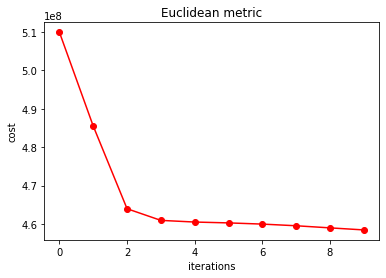

In [9]:
iter_costs = kmeans_cost(ITERATIONS, points, centroids, Euclidean)

print_costs(iter_costs)
plot_costs(iter_costs, 'Euclidean metric')

#### Manhattan metric

0:       464869.28
1:       470897.38
2:       483914.41
3:       489216.07
4:       487629.67
5:       483711.92
6:       475330.77
7:       474871.24
8:       457232.92
9:       447494.39

Cost change: 3.74%


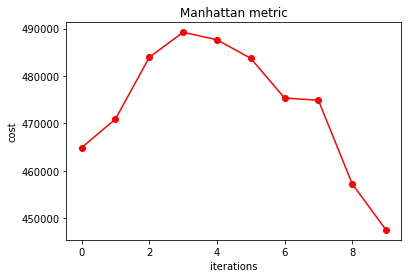

In [10]:
iter_costs = kmeans_cost(ITERATIONS, points, centroids, Manhattan)

print_costs(iter_costs)
plot_costs(iter_costs, 'Manhattan metric')

### Centers from points located furthest away from each other 

In [11]:
centroids = np.loadtxt('3/3c.txt')

#### Euclidean metric

0:    249803933.63
1:    194494814.41
2:    169804841.45
3:    156295748.81
4:    149094208.11
5:    142508531.62
6:    132303869.41
7:    117170969.84
8:    108547377.18
9:    102237203.32

Cost change: 59.07%


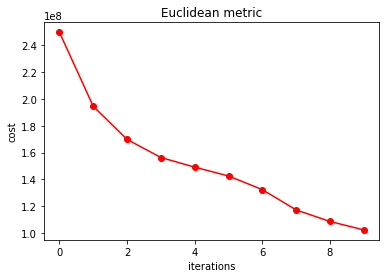

In [12]:
iter_costs = kmeans_cost(ITERATIONS, points, centroids, Euclidean)

print_costs(iter_costs)
plot_costs(iter_costs, 'Euclidean metric')

#### Manhattan metric

0:      1084488.78
1:       973431.71
2:       895934.59
3:       865128.34
4:       845846.65
5:       827219.58
6:       803590.35
7:       756039.52
8:       717332.90
9:       694587.93

Cost change: 35.95%


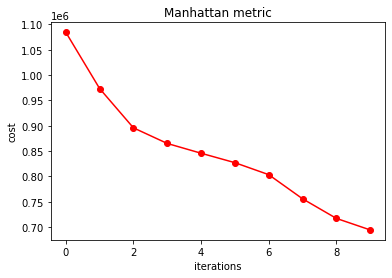

In [13]:
iter_costs = kmeans_cost(ITERATIONS, points, centroids, Manhattan)

print_costs(iter_costs)
plot_costs(iter_costs, 'Manhattan metric')

In [14]:
sc.stop()